# ECE449: Assignment 3
- Jie Wang
- 3200112404



## 1. N-Gram model

Assume any n-gram not seen in the training set has a probability count of 1 (using Add-One Smoothing). 

replace punctuation with spaces and convert to lowercase

You would first need to calculate the frequency of each bigram and trigram in the training set, then apply Add-One Smoothing to estimate probabilities. For the test sentences, you would calculate the probability of each sentence as the product of the probabilities of its big rams or trigrams. 

training_sentences = [
    "the sky is blue",
    "the sun is bright",
    "the sun in the blue sky is bright",
    "we can see the shining sun, the bright sun"
]

bigram_model = NGramModel(2)
trigram_model = NGramModel(3)

bigram_model.train(training_sentences)
trigram_model.train(training_sentences)

test_sentences = ["the sun is", "the sun is shining"]


In [1]:
import re
from collections import Counter, defaultdict
from itertools import islice, tee

class NGramModel:
    def __init__(self, n):
        self.n = n
        self.ngram_counts = Counter()
        self.context_counts = Counter()
        self.vocabulary = set()
        self.vocabulary_size = 0

    def tokenize(self, text):
        # here, I took the strategy learned from https://web.stanford.edu/~jurafsky/slp3/3.pdf
        # replace punctuation with spaces and convert to lowercase
        text = re.sub(r'[^\w\s]', ' ', text).lower()
        return text.split()

    def ngrams(self, tokens):
        # Helper function to generate n-grams from tokens
        return zip(*[islice(seq, i, None) for i, seq in enumerate(tee(tokens, self.n))])

    def update_counts(self, sentence):
        tokens = self.tokenize(sentence) 
        print(tokens)
        self.vocabulary.update(tokens)
        self.vocabulary_size = len(self.vocabulary)

        for ngram in self.ngrams(tokens):
            self.ngram_counts[ngram] += 1
            context = ngram[:-1]
            self.context_counts[context] += 1

    def train(self, sentences):
        for sentence in sentences:
            self.update_counts(sentence)

    def calculate_probability(self, ngram):
        context = ngram[:-1]
        count = self.ngram_counts[ngram]
        context_count = self.context_counts[context]
        # Add-One Smoothing
        probability = (count + 1) / (context_count + self.vocabulary_size)
        return probability

    def sentence_probability(self, sentence):
        tokens = self.tokenize(sentence)
        probability = 1.0
        for ngram in self.ngrams(tokens):
            probability *= self.calculate_probability(ngram)
        return probability

training_sentences = [
    "the sky is blue",
    "the sun is bright",
    "the sun in the blue sky is bright",
    "we can see the shining sun, the bright sun"
]

bigram_model = NGramModel(2)
trigram_model = NGramModel(3)

bigram_model.train(training_sentences)
trigram_model.train(training_sentences)

test_sentences = ["the sun is", "the sun is shining"]

for sentence in test_sentences:
    bigram_prob = bigram_model.sentence_probability(sentence)
    trigram_prob = trigram_model.sentence_probability(sentence)
    print(f"Sentence: '{sentence}' | Bigram Probability: {bigram_prob} | Trigram Probability: {trigram_prob}")


['the', 'sky', 'is', 'blue']
['the', 'sun', 'is', 'bright']
['the', 'sun', 'in', 'the', 'blue', 'sky', 'is', 'bright']
['we', 'can', 'see', 'the', 'shining', 'sun', 'the', 'bright', 'sun']
['the', 'sky', 'is', 'blue']
['the', 'sun', 'is', 'bright']
['the', 'sun', 'in', 'the', 'blue', 'sky', 'is', 'bright']
['we', 'can', 'see', 'the', 'shining', 'sun', 'the', 'bright', 'sun']
Sentence: 'the sun is' | Bigram Probability: 0.025210084033613446 | Trigram Probability: 0.15384615384615385
Sentence: 'the sun is shining' | Bigram Probability: 0.001800720288115246 | Trigram Probability: 0.01282051282051282


## Q2: Naive Bayes

Given the 'Car Evaluation'dataset, your goal is to predict the decision of car evaluation (unacc, ace, good, vgood) based on the attributes provided. You are required to train a Naive Bayes classifier to perform this task. 
Attributes: 
•	Buying price (vhigh, high, med, low)
•	Maintenance cost (vhigh, high, med, low)
•	Number of doors (2, 3, 4) 
•	Number of persons (2, 3, 4) 
•	Luggage boot size (small, med, big)
•	Safety (low, med, high)

In [19]:

import pandas as pd
import numpy as np

def naive_bayes_predict(X, prior_probabilities, likelihood):
    predictions = []
    for _, instance in X.iterrows():
        class_probabilities = {}
        for class_value in prior_probabilities.index:
            class_prob = prior_probabilities[class_value]
            for feature in X.columns:
                feature_value = instance[feature]
                class_prob *= likelihood[feature].loc[feature_value, class_value]
            class_probabilities[class_value] = class_prob
        predicted_class = max(class_probabilities, key=class_probabilities.get)
        predictions.append(predicted_class)
    return predictions

train_data_path = 'train_set.csv' 
train_data = pd.read_csv(train_data_path)

# Split into features and labels
X_train = train_data.drop(['Quality', 'ID'], axis=1)
Y_train = train_data['Quality']

# prior probabilities of each class
prior_probabilities = Y_train.value_counts(normalize=True)
print(prior_probabilities)
# likelihood of each attribute value given each class
likelihood = {}
for column in X_train.columns:
    likelihood[column] = pd.crosstab(X_train[column], Y_train, normalize='columns')
print(likelihood)
test_data_path = 'test_set.csv'  # Replace with actual path
test_data = pd.read_csv(test_data_path)

# Split into features and labels
X_test = test_data.drop(['Quality', 'ID'], axis=1)

predictions = naive_bayes_predict(X_test, prior_probabilities, likelihood)

predictions

Quality
unacc    0.6
acc      0.2
vgood    0.1
good     0.1
Name: proportion, dtype: float64
{'Buying Price': Quality        acc  good     unacc  vgood
Buying Price                             
high          0.75   0.0  0.166667    0.0
low           0.00   0.5  0.000000    0.5
med           0.25   0.5  0.416667    0.0
ow            0.00   0.0  0.000000    0.5
vhigh         0.00   0.0  0.416667    0.0, 'Maintenance Cost': Quality            acc  good     unacc  vgood
Maintenance Cost                             
high              0.00   0.0  0.416667    1.0
low               0.25   1.0  0.083333    0.0
med               0.75   0.0  0.166667    0.0
vhigh             0.00   0.0  0.333333    0.0, 'Number of Doors': Quality           acc  good     unacc  vgood
Number of Doors                             
2                0.75   0.0  0.750000    0.0
3                0.25   0.5  0.166667    1.0
4                0.00   0.5  0.083333    0.0, 'Number of Persons': Quality            acc  good    

['unacc', 'unacc', 'unacc']

## visualization
To visualize the performance of the Naive Bayes classifier, we typically use metrics such as confusion matrices, ROC curves, or precision-recall curves. However, since we don't have the actual labels for the test set, we can't compute these metrics directly.

Therefore, I visualize the probabilities assigned by the Naive Bayes model to different attributes for each class.

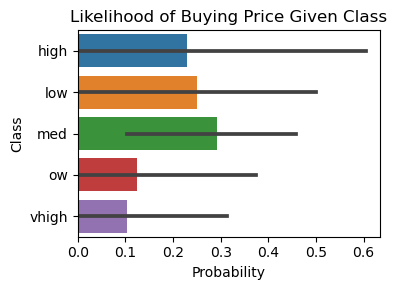

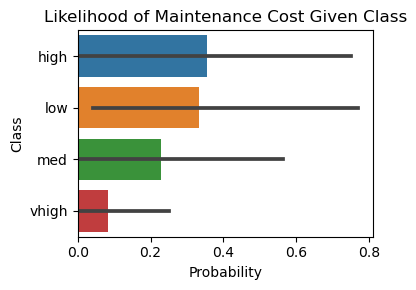

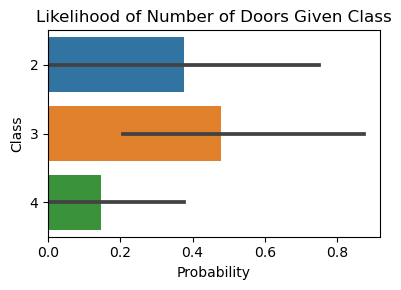

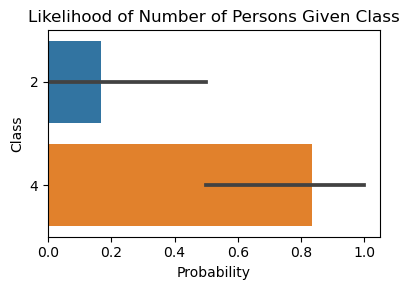

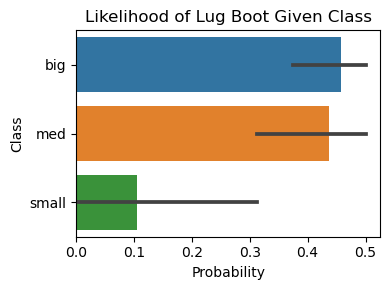

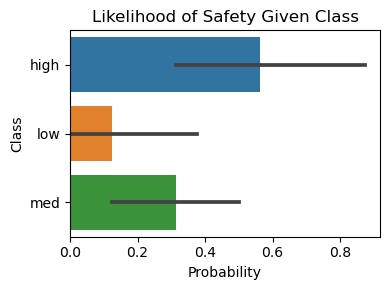

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

for feature in likelihood:
    plt.figure(figsize=(4, 3))
    sns.barplot(data=likelihood[feature].T, orient='h')
    plt.title(f'Likelihood of {feature} Given Class')
    plt.xlabel('Probability')
    plt.ylabel('Class')
    plt.tight_layout()
    plt.show()


Furthermore, I find the external variation of each feature. It seems the maintenance cost is most impactful to the evaluation of car quality.

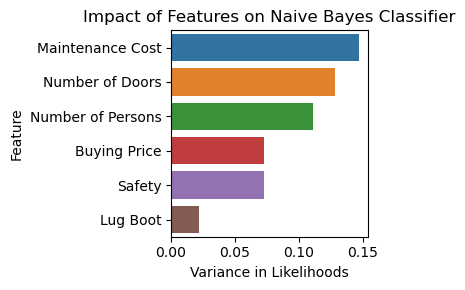

In [12]:
# variance in likelihoods for each feature
feature_impact = {}
for feature in likelihood:
    feature_impact[feature] = likelihood[feature].var(axis=1).mean()

sorted_features = sorted(feature_impact.items(), key=lambda x: x[1], reverse=True)

impact_df = pd.DataFrame(sorted_features, columns=['Feature', 'Variance'])

# Visualizing the impact of each feature
plt.figure(figsize=(4, 3))
sns.barplot(x='Variance', y='Feature', data=impact_df)
plt.title('Impact of Features on Naive Bayes Classifier')
plt.xlabel('Variance in Likelihoods')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


It's 

## Q3. Logistic Regression Problem
### Problem: 
Using the following dataset, implement the logistic regression algorithm to predict the probability of passing an exam based on hours studied. Initialize the weight w at O and bias b at 0. Use a step size of 0.01 and update the parameters until the change in the log-likelihood function is less than 0.001. 
| Hours studied | result |
| ------------- | ------ |
| 1             | fail   |
| 2             | fail   |
| 4             | pass   |
| 6             | pass   |


You would need to implement the gradient ascent algorithm to maximize the log-likelihood. It will iteratively update the weight and bias based on the gradient of the log-likelihood with respect to w and b. 




In [13]:
import numpy as np

Hours = np.array([1, 2, 4, 6])  
Results = np.array([0, 0, 1, 1])  # 0 for fail, 1 for pass

# Logistic Regression Model
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def log_likelihood(X, Y, w, b):
    likelihood = 0
    for x, y in zip(X, Y):
        likelihood += y * np.log(sigmoid(w * x + b)) + (1 - y) * np.log(1 - sigmoid(w * x + b))
    return likelihood

def gradient_ascent(X, Y, step_size, threshold):
    w, b = 0, 0
    likelihood = log_likelihood(X, Y, w, b)
    change = float('inf')

    while change > threshold:
        w_grad, b_grad = 0, 0
        for x, y in zip(X, Y):
            w_grad += x * (y - sigmoid(w * x + b))
            b_grad += y - sigmoid(w * x + b)

        w_new = w + step_size * w_grad
        b_new = b + step_size * b_grad

        new_likelihood = log_likelihood(X, Y, w_new, b_new)
        change = new_likelihood - likelihood

        w, b = w_new, b_new
        likelihood = new_likelihood

    return w, b

final_weight, final_bias = gradient_ascent(Hours, Results, 0.01, 0.001)
final_weight, final_bias


(0.9922916269658583, -2.563586408390352)

## Q4: Decision Tree Problem

### Problem Statement: 
Using the 'Car Evaluation'Dataset provided above, construct a decision tree to predict the evaluation of a car (unacc, ace, good, vgood). Your task is to calculate the information gain for each attribute and draw the decision tree based on the calculated information gain. 

In [14]:
from sklearn.tree import DecisionTreeClassifier, export_text

# Loading the training data
train_data = pd.read_csv('train_set.csv')

X_train = train_data.drop(['Quality', 'ID'], axis=1)  # Removing 'ID' as it's not a feature
Y_train = train_data['Quality']

# Encode categorical features as a one-hot numeric array
X_train_encoded = pd.get_dummies(X_train)

# Creating and fitting the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(criterion='entropy')
dt_classifier.fit(X_train_encoded, Y_train)

# Extracting the decision tree rules
tree_rules = export_text(dt_classifier, feature_names=list(X_train_encoded.columns))
tree_rules



'|--- Number of Persons <= 3.00\n|   |--- class: unacc\n|--- Number of Persons >  3.00\n|   |--- Safety_low <= 0.50\n|   |   |--- Maintenance Cost_high <= 0.50\n|   |   |   |--- Buying Price_vhigh <= 0.50\n|   |   |   |   |--- Maintenance Cost_low <= 0.50\n|   |   |   |   |   |--- class: acc\n|   |   |   |   |--- Maintenance Cost_low >  0.50\n|   |   |   |   |   |--- Safety_med <= 0.50\n|   |   |   |   |   |   |--- class: good\n|   |   |   |   |   |--- Safety_med >  0.50\n|   |   |   |   |   |   |--- Buying Price_low <= 0.50\n|   |   |   |   |   |   |   |--- class: acc\n|   |   |   |   |   |   |--- Buying Price_low >  0.50\n|   |   |   |   |   |   |   |--- class: good\n|   |   |   |--- Buying Price_vhigh >  0.50\n|   |   |   |   |--- class: unacc\n|   |   |--- Maintenance Cost_high >  0.50\n|   |   |   |--- class: vgood\n|   |--- Safety_low >  0.50\n|   |   |--- class: unacc\n'

The final result we obtained is: 
```sql
- If 'Number of Persons' <= 3.00: Predict 'unacc'
- Else if 'Number of Persons' > 3.00:
    - If 'Safety_low' <= 0.50:
        - If 'Maintenance Cost_high' <= 0.50:
            - If 'Maintenance Cost_vhigh' <= 0.50:
                - If 'Buying Price_high' <= 0.50:
                    - If 'Buying Price_med' <= 0.50: Predict 'good'
                    - Else if 'Buying Price_med' > 0.50:
                        - If 'Safety_med' <= 0.50: Predict 'good'
                        - Else if 'Safety_med' > 0.50: Predict 'acc'
                - Else if 'Buying Price_high' > 0.50: Predict 'acc'
            - Else if 'Maintenance Cost_vhigh' > 0.50: Predict 'unacc'
        - Else if 'Maintenance Cost_high' > 0.50: Predict 'vgood'
    - Else if 'Safety_low' > 0.50: Predict 'unacc'
```